Notebook created by [Mattia Loszach](https://mattia-loszach.com)

**Disclaimer:** This notebook should be used as a tool for scenario analysis and risk assessment, not as a standalone forecast.

---

# Stock Portfolio Risk Assessment using Monte Carlo Simulation

In [115]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Choose your assets
This code allows selecting assets and specifying their quantities using ticker symbols from the Yahoo Finance API. For missing or unknown tickers, check the [Yahoo Finance Website](https://finance.yahoo.com). Start by running the following code cell and you will be able to input the assets.

Enter your assets and their quantities line by line in the format: TICKER QUANTITY
Type 'done', 'q', or 'quit' to finish.


Enter asset and quantity (or 'done' to finish):  msft 1
Enter asset and quantity (or 'done' to finish):  nvda 1
Enter asset and quantity (or 'done' to finish):  aapl 1
Enter asset and quantity (or 'done' to finish):  gogl


Invalid format. Please enter in the format: TICKER QUANTITY


Enter asset and quantity (or 'done' to finish):  gogl 1
Enter asset and quantity (or 'done' to finish):  done




-------------------Your Portfolio-------------------
MSFT : 1
NVDA : 1
AAPL : 1
GOGL : 1
----------------------------------------------------


[*********************100%***********************]  4 of 4 completed

Initial Portfolio Value: $841.09



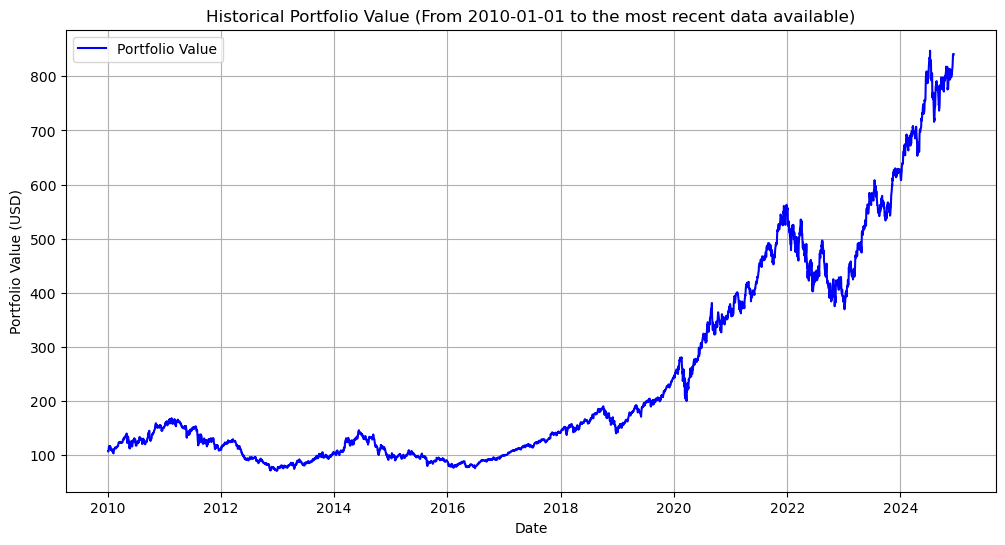

Final Portfolio Value: $841.09


In [117]:
def is_valid_ticker(ticker):
    """
    Checks if Asset exists in the Yahoo Finance API.
    """
    try:
        data = yf.Ticker(ticker).history(period="1d")
        return not data.empty
    except Exception:
        return False

def get_assets_and_shares():
    print("Enter your assets and their quantities line by line in the format: TICKER QUANTITY")
    print("Type 'done', 'q', or 'quit' to finish.")
    
    assets = []
    shares = []
    
    while True:
        user_input = input("Enter asset and quantity (or 'done' to finish): ").strip()
        if user_input.lower() in ['done', 'q', 'quit']:
            break
        
        try:
            ticker, quantity = user_input.split()  # Split input into ticker and quantity

            if not quantity.isdigit():
                print("Invalid format. Quantity must be an integer.")
                continue

            if not is_valid_ticker(ticker):
                print(f"Error: '{ticker}' is not a valid ticker. Please try again. Search 'https://finance.yahoo.com/' for help.")
                continue
            
            assets.append(ticker.strip().upper())
            shares.append(int(quantity.strip()))
            
        except ValueError:
            print("Invalid format. Please enter in the format: TICKER QUANTITY")
    
    return assets, shares

# Get user input
assets, shares = get_assets_and_shares()
print("\n")
print("-------------------Your Portfolio-------------------")
for i in range(len(assets)):
    print(assets[i], ":", shares[i])
print("----------------------------------------------------")

# Plot history of portolio
data = yf.download(assets, start='2010-01-01', threads=False)['Close']
daily_returns = data.pct_change(fill_method=None).dropna()
last_prices = data.iloc[-1]
initial_portfolio_value = sum(np.array(shares) * last_prices.values)
print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}\n")

portfolio_values = data @ shares
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Portfolio Value", color="blue")
plt.title("Historical Portfolio Value (From 2010-01-01 to the most recent data available)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.grid(True)
plt.legend()
plt.show()

last_portfolio_value = portfolio_values.iloc[-1]
print(f"Final Portfolio Value: ${last_portfolio_value:.2f}")


## Choose Parameters for Simulation
By default, periods is set to 252 days, representing a typical trading year in the stock market, and simulations is set to 1000 runs. Users can customize these parameters to suit their preferences.

In [118]:
periods = 252 # Unit: Days
n_simulations = 1000 # Unit: Number of Simulations

## Context & Run simulation

---


This simulation models the price evolution of multiple assets using the [Geometric Brownian Motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)  in a multivariate context, which accounts for asset correlations. 
### 1. **Drift and Volatility**
The drift term $\mu$ and volatility term $\sigma$ for each asset are calculated from historical daily returns:

- $\mu_i$ = mean of daily returns for asset i
- $\sigma_i$ = standard deviation of daily returns for asset i

The drift for the simulation is adjusted using:
$$
\text{Drift} = \mu - \frac{1}{2} \sigma^2
$$
This adjustment ensures consistency with the GBM model.

### 2. **Correlation Matrix and Cholesky Decomposition**
To model dependencies between assets, the correlation matrix $\mathbf{C}$ is calculated from the historical daily returns. The **Cholesky decomposition** is used to transform independent standard normal random variables into correlated random variables:
$$
\mathbf{L} \text{ such that } \mathbf{C} = \mathbf{L} \mathbf{L}^\top
$$

### 3. **Random Sampling**
For $n_{\text{simulations}}$ Monte Carlo simulations over $T$ periods, random standard normal variables are generated:
$$
Z_{i,t} \sim \mathcal{N}(0, 1)
$$
These are transformed into correlated random values using:
$$
\text{Correlated Random Values} = \mathbf{L} \cdot \mathbf{Z}
$$

### 4. **Asset Price Evolution**
Using the GBM formula, the simulated prices are calculated iteratively:
$$
S_{i, t+1} = S_{i, t} \cdot \exp\left( \text{Drift}_i \cdot \Delta t + \sigma_i \cdot \sqrt{\Delta t} \cdot \text{Correlated Random Values}\right)
$$
Where:
- $S_{i, t}$ is the price of asset $i$ at time $t$,
- $\Delta t = 1$ represents daily time steps.

### 5. **Portfolio Value**
The simulated portfolio value is computed as the weighted sum of asset prices, based on the number of shares held:
$$
V_{\text{portfolio}, t} = \sum_{i=1}^{N} \text{Shares}_i \cdot S_{i, t}
$$

---

### Summary of Code Steps:
1. **Drift and Volatility**: Pre-compute drift and volatility terms for each asset.
2. **Cholesky Decomposition**: Use the correlation matrix to generate correlated random samples.
3. **Simulated Prices**: Use the GBM formula iteratively for price evolution.
4. **Portfolio Value**: Aggregate asset values to get the portfolio value at each step.


In [119]:
mean_returns = daily_returns.mean().to_numpy()
volatilities = daily_returns.std().to_numpy()
correlation_matrix = daily_returns.corr().to_numpy()
L = np.linalg.cholesky(correlation_matrix)

def monte_carlo_simulation(assets, shares, periods, n_simulations, mean_returns, volatilities, last_prices, L):
    dt = 1
    drift = mean_returns - 0.5 * volatilities**2

    random_values = np.random.normal(0, 1, (len(assets), periods, n_simulations))
    correlated_random_values = np.zeros_like(random_values)
    for t in range(periods):
      correlated_random_values[:, t, :] = L @ random_values[:, t, :]

    simulated_prices = np.zeros((len(assets), periods, n_simulations))
    simulated_prices[:, 0, :] = last_prices.values[:, np.newaxis]

    for t in range(1, periods):
        simulated_prices[:, t, :] = simulated_prices[:, t - 1, :] * np.exp(
            drift[:, np.newaxis] * dt + volatilities[:, np.newaxis] * np.sqrt(dt) * correlated_random_values[:, t, :]
        )

    portfolio_prices = np.tensordot(shares, simulated_prices, axes=(0, 0))
    return portfolio_prices, simulated_prices

portfolio_prices, simulated_asset_prices = monte_carlo_simulation(
    assets, shares, periods, n_simulations, mean_returns, volatilities, last_prices, L
)

## Results

---

### Interpreting Monte Carlo Simulation Results

Monte Carlo simulations provide a powerful framework for analyzing the potential future performance of a portfolio. However, it is crucial to understand their limitations and how to interpret the results effectively:

1. **Visual Exploration**: 
   - The results can be visualized in various ways, such as line plots, histograms, confidence intervals, and boxplots. Each visualization highlights different aspects of the portfolio's behavior, such as overall trends, risk, and uncertainty.

2. **Guidance, Not Prediction**:
   - These simulations do not predict the market or asset prices with absolute accuracy. Instead, they offer guidance by providing a range of possible outcomes based on historical data and assumptions about volatility, drift, and correlations.

3. **Key Metrics**:
   - Statistical measures such as the mean, median, standard deviation, and percentiles (e.g., 5th and 95th) help quantify risk and expected returns.
   - Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR) give insights into potential losses under adverse conditions.

4. **Use in Decision-Making**:
   - Simulations should be used as a tool for scenario analysis and risk assessment, not as a standalone forecast.

By combining graphical analysis and key metrics, Monte Carlo simulations allow investors to evaluate the uncertainty in portfolio performance and make more informed decisions.


### Key metrics

In [120]:
end_prices = portfolio_prices[-1]

mean_end_value = np.mean(end_prices)
median_end_value = np.median(end_prices)
std_end_value = np.std(end_prices)
min_end_value = np.min(end_prices)
max_end_value = np.max(end_prices)
percentile_5 = np.percentile(end_prices, 5)
percentile_95 = np.percentile(end_prices, 95)

print("--------------Initial Portfolio Value--------------\n")
print(f"Started with: ${initial_portfolio_value:.2f}\n")
print("---------------------------------------------------\n")

print("Portfolio End Values - Key Statistics:")
print(f"  Mean Value: ${mean_end_value:,.2f}")
print(f"  Median Value: ${median_end_value:,.2f}")
print(f"  Standard Deviation: ${std_end_value:,.2f}")
print(f"  Minimum Value: ${min_end_value:,.2f}")
print(f"  Maximum Value: ${max_end_value:,.2f}")
print(f"  5th Percentile (VaR 95%): ${percentile_5:,.2f}")
print(f"  95th Percentile: ${percentile_95:,.2f}")

--------------Initial Portfolio Value--------------

Started with: $841.09

---------------------------------------------------

Portfolio End Values - Key Statistics:
  Mean Value: $1,100.21
  Median Value: $1,069.44
  Standard Deviation: $288.37
  Minimum Value: $432.88
  Maximum Value: $2,630.01
  5th Percentile (VaR 95%): $707.36
  95th Percentile: $1,602.09


## Monte Carlo Simulation

In [124]:
visible_simulations = 100 # You can change this value

if visible_simulations > n_simulations:
    raise ValueError(f"Your Monte Carlo simulation only computed {n_simulations} simulations. Please choose a value smaller or equal to that.")

print(f"{n_simulations} simulations were computed. You are displaying ({visible_simulations}/{n_simulations}) simulations.")

1000 simulations were computed. You are displaying (100/1000) simulations.


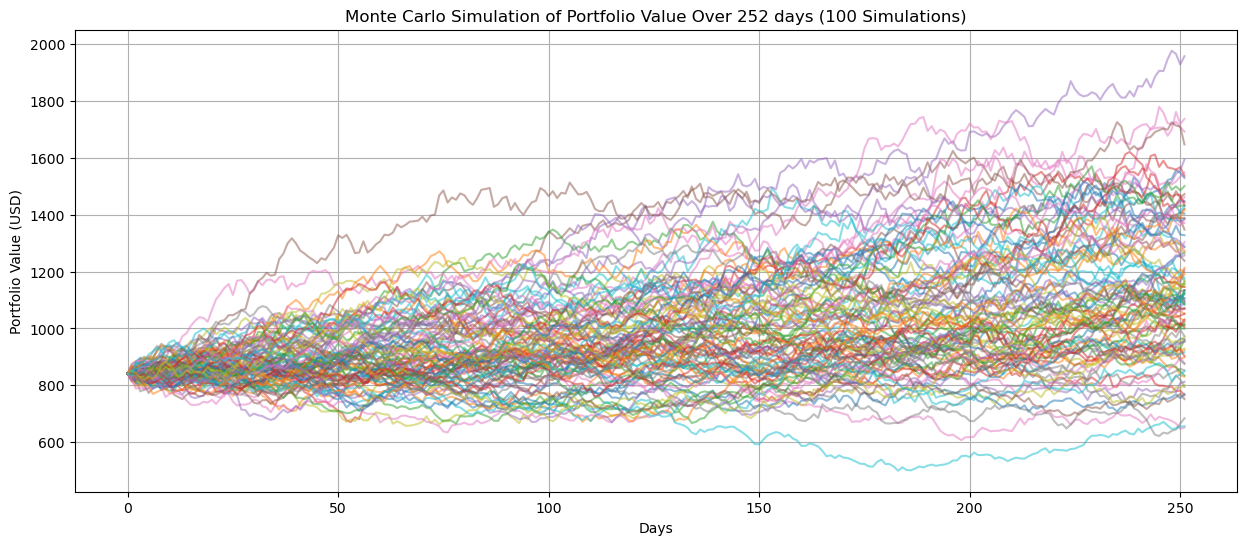

In [125]:
# Basic Monte Carlo Simulation
plt.figure(figsize=(15, 6))
for i in range(visible_simulations):
    plt.plot(portfolio_prices[:, i], alpha=0.5)
plt.title(f'Monte Carlo Simulation of Portfolio Value Over {periods} days ({visible_simulations} Simulations)')
plt.xlabel('Days')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.show()

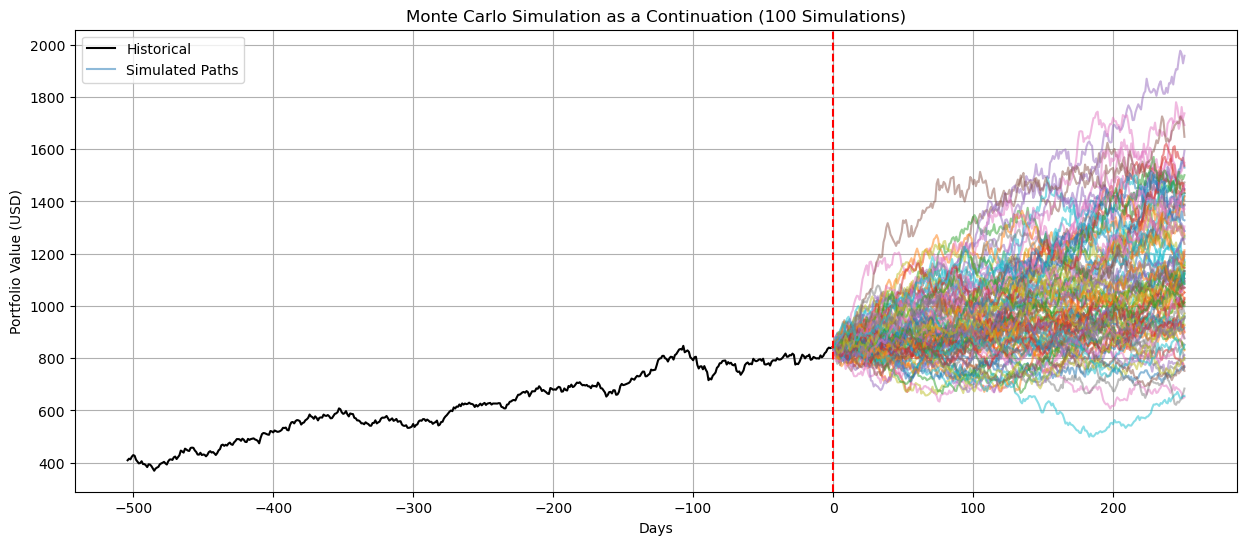

In [126]:
# Continuous Plot
plt.figure(figsize=(15, 6))
historical_portfolio = data @ shares
historical_days = len(historical_portfolio)
past_time_frame = 504
historical_portfolio_time_frame = historical_portfolio[-past_time_frame:]

plt.plot(np.arange(-past_time_frame, 0), historical_portfolio_time_frame, label='Historical Portfolio Value', color='black')
plt.plot(
    np.arange(0, periods),
    portfolio_prices[:, :visible_simulations],
    alpha=0.5
)
plt.title(f'Monte Carlo Simulation as a Continuation ({visible_simulations} Simulations)')
plt.xlabel('Days')
plt.ylabel('Portfolio Value (USD)')
plt.axvline(0, color='red', linestyle='--', label='Today')
plt.legend(['Historical', 'Simulated Paths'])
plt.grid(True)
plt.show()

## Histogram of Portfolio End Values

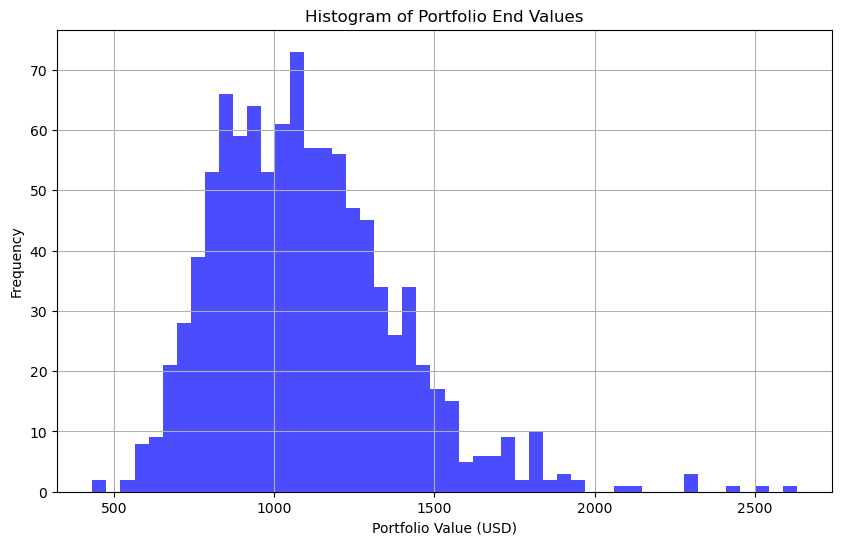

In [127]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(end_prices, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Portfolio End Values')
plt.xlabel('Portfolio Value (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Confidence Interval

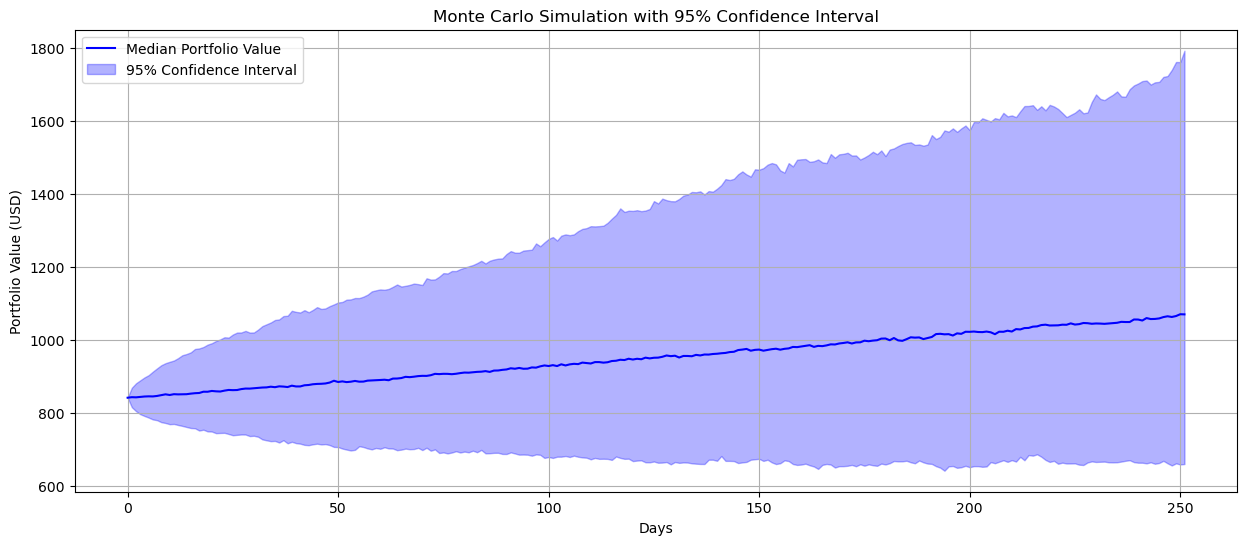

In [128]:
# Confidence Interval
percentiles = [2.5, 50, 97.5]
conf_intervals = np.percentile(portfolio_prices, percentiles, axis=1)

plt.figure(figsize=(15, 6))
plt.plot(conf_intervals[1], label='Median Portfolio Value', color='blue')
plt.fill_between(
    np.arange(periods),
    conf_intervals[0],
    conf_intervals[2],
    color='blue',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.title('Monte Carlo Simulation with 95% Confidence Interval')
plt.xlabel('Days')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Histogram with Risk Metrics: VaR (5%) and CVaR (5%)

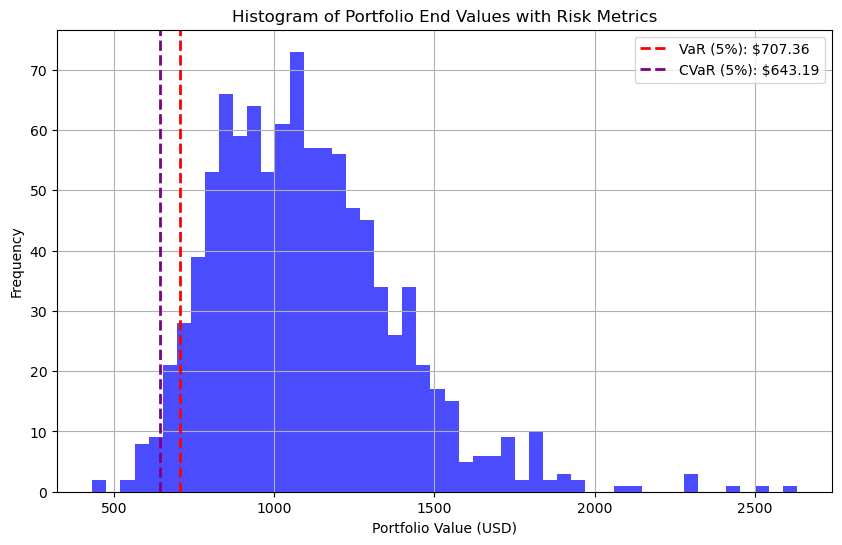

In [129]:
# Histogram with Risk Metrics
VaR_5 = np.percentile(end_prices, 5)  # 5% Value at Risk
CVaR_5 = end_prices[end_prices <= VaR_5].mean()  # Conditional VaR (Average of worst 5%)

plt.figure(figsize=(10, 6))
plt.hist(end_prices, bins=50, color='blue', alpha=0.7)
plt.axvline(VaR_5, color='red', linestyle='dashed', linewidth=2, label=f'VaR (5%): ${VaR_5:.2f}')
plt.axvline(CVaR_5, color='purple', linestyle='dashed', linewidth=2, label=f'CVaR (5%): ${CVaR_5:.2f}')
plt.title('Histogram of Portfolio End Values with Risk Metrics')
plt.xlabel('Portfolio Value (USD)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## Boxplot

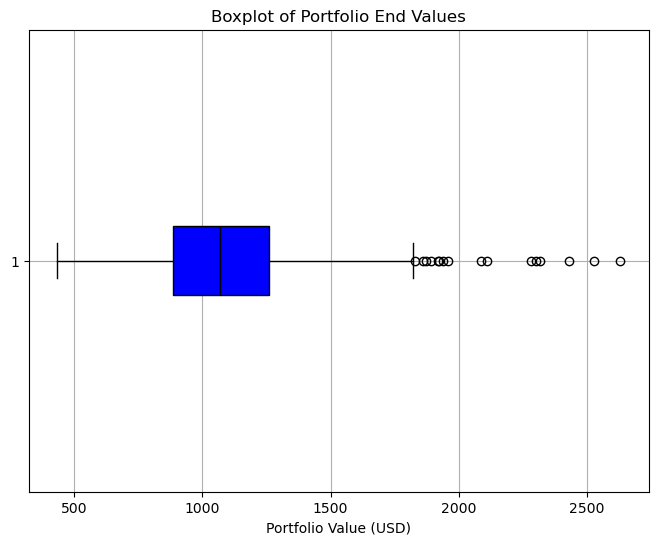

In [130]:
# Boxplot für Endwerte
plt.figure(figsize=(8, 6))
plt.boxplot(portfolio_prices[-1], vert=False, patch_artist=True,
            boxprops=dict(facecolor='blue', color='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'))

plt.title('Boxplot of Portfolio End Values')
plt.xlabel('Portfolio Value (USD)')
plt.grid(True)
plt.show()

## Maximum Drawdowns

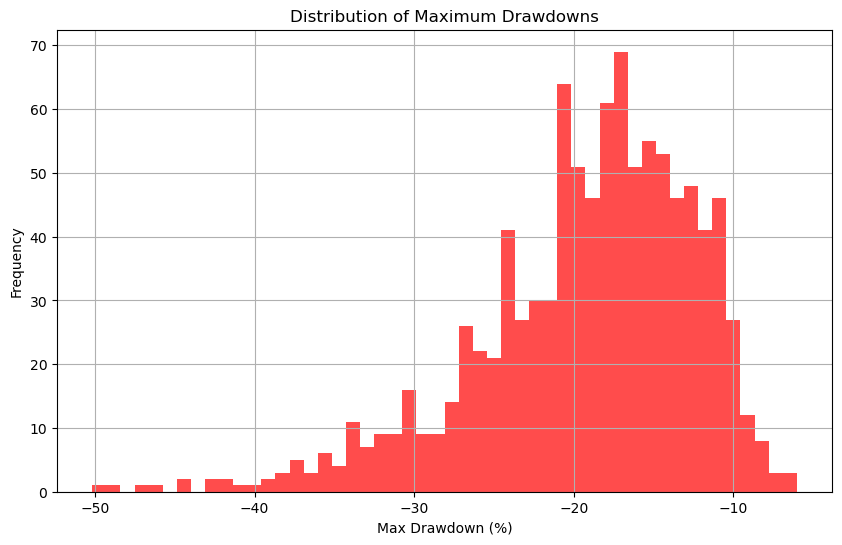

In [131]:
# Maximum Drawdowns
max_drawdowns = np.zeros(n_simulations)
for i in range(n_simulations):
    cumulative_returns = portfolio_prices[:, i] / portfolio_prices[0, i]
    max_drawdowns[i] = np.min(cumulative_returns / np.maximum.accumulate(cumulative_returns) - 1)

plt.figure(figsize=(10, 6))
plt.hist(max_drawdowns*100, bins=50, color='red', alpha=0.7)
plt.title('Distribution of Maximum Drawdowns')
plt.xlabel('Max Drawdown (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Heatmap (Correlation Matrix of Assets)

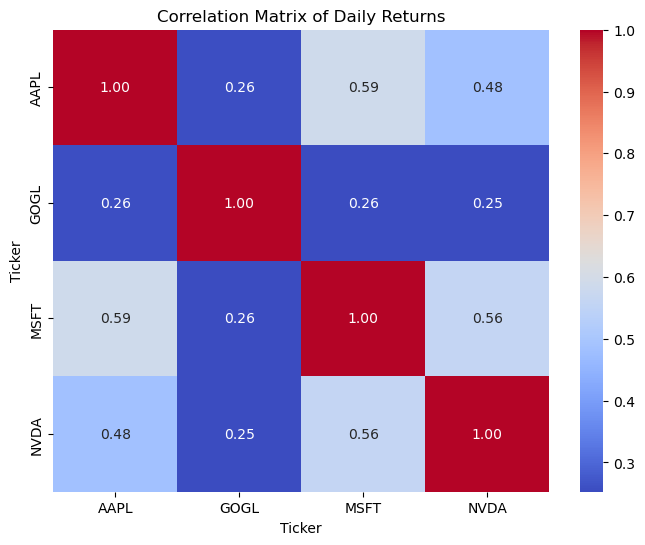

In [132]:
# Heatmap for Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    daily_returns.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar=True
)
plt.title('Correlation Matrix of Daily Returns')
plt.show()

---

© 2024 by Mattia Loszach

**Sources and References**
- [Monte Carlo Simulation on Investopedia](https://www.investopedia.com/terms/m/montecarlosimulation.asp)
- [Wikipedia Geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)
- [yfinance Python Library on GitHub](https://github.com/ranaroussi/yfinance)
- [Value at Risk (VaR) Explained](https://www.investopedia.com/terms/v/var.asp)  
- [Conditional Value at Risk (CVaR)](https://www.investopedia.com/terms/c/conditional_value_at_risk.asp)
